In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# !pip install gensim
!pip install transformers
import nltk
!pip install torchmetrics
# !pip install mca
from matplotlib import pyplot as plt
import seaborn as sns
!pip install spicy
!pip install torch
# !pip install spacy
# !python -m spacy download en_core_web_lg

# !pip install wordcloud
# !pip install umap-learn

# from wordcloud import WordCloud
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer
import nltk
import numpy as np
df=pd.read_csv("/kaggle/input/name-entity-recognition-ner-dataset/NER dataset.csv",encoding='unicode_escape')
# df = df.loc[:10000,:]
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


# Preparing Data

In [3]:
import seaborn as sns
counts = df["POS"].value_counts()
to_change = counts[counts < 1000].index.values
df.loc[df["POS"].isin(to_change),"POS"]="OTHER"

In [4]:
from sklearn.preprocessing import OneHotEncoder
import torch
oh = OneHotEncoder(sparse_output=False)
pos_oh = oh.fit_transform(df.loc[:,["POS"]])
oh = OneHotEncoder(sparse_output=False)
target_oh=oh.fit_transform(df.loc[:,["Tag"]])
df=df.astype({"Sentence #":"string","Word": "string","Tag": "string"})

In [5]:
labels=oh.categories_[0]
id_to_label  = dict(enumerate(labels))
label_to_id = dict([(i,j) for (j,i) in enumerate(labels)])
label_to_id,id_to_label

({'B-art': 0,
  'B-eve': 1,
  'B-geo': 2,
  'B-gpe': 3,
  'B-nat': 4,
  'B-org': 5,
  'B-per': 6,
  'B-tim': 7,
  'I-art': 8,
  'I-eve': 9,
  'I-geo': 10,
  'I-gpe': 11,
  'I-nat': 12,
  'I-org': 13,
  'I-per': 14,
  'I-tim': 15,
  'O': 16},
 {0: 'B-art',
  1: 'B-eve',
  2: 'B-geo',
  3: 'B-gpe',
  4: 'B-nat',
  5: 'B-org',
  6: 'B-per',
  7: 'B-tim',
  8: 'I-art',
  9: 'I-eve',
  10: 'I-geo',
  11: 'I-gpe',
  12: 'I-nat',
  13: 'I-org',
  14: 'I-per',
  15: 'I-tim',
  16: 'O'})

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

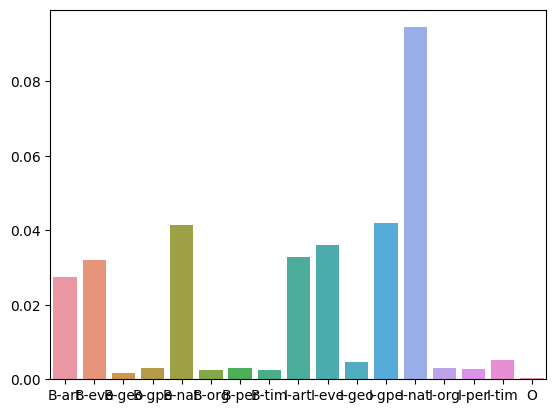

In [6]:
value_coefs = 1 / np.power(df["Tag"].value_counts(),0.6)
coefs = torch.tensor([value_coefs[key] for key in label_to_id.keys()]).float()
sns.barplot(x=list(label_to_id.keys()),y=np.array(coefs))

In [7]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
  
snow_stemmer = SnowballStemmer(language='english')
def snow_stem(word):
    return snow_stemmer.stem(word) if not pd.isna(word) else word
sn_stem = np.vectorize(snow_stem)
df["StWord"]=sn_stem(df["Word"])   

In [8]:
sequence_tokens,sequence_pos,sequence_target = [],[],[]
df_processed = []
for i in range(df.shape[0]):
    word = df.iloc[i]["Word"]
    sentence = df.iloc[i]["Sentence #"]
    pos = pos_oh[i]
    target = target_oh[i]

    if(not pd.isna(sentence) and "Sentence" in sentence and len(sequence_tokens) > 0):
        df_processed.append({"tokens": sequence_tokens,"pos": sequence_pos,"target": sequence_target})
        sequence_tokens,sequence_pos,sequence_target = [],[],[]
    else : 
        sequence_tokens.append(word)
        sequence_pos.append(pos)
        sequence_target.append(target)

In [9]:
import random
train_indices=np.array(random.sample(range(0,len(df_processed)),int(0.85*len(df_processed))))
valid_indices = np.setdiff1d(np.array(range(0,len(df_processed))),train_indices)
df_series = pd.Series(df_processed)
train=df_series[train_indices].values
valid = df_series[valid_indices].values
train=np.array(sorted(train, key=lambda item1:len(item1["tokens"])))
valid=np.array(sorted(valid, key=lambda item1:len(item1["tokens"])))
valid.shape,train.shape

((7194,), (40762,))

In [10]:
from random import randint
import functools 
import itertools 

from collections import defaultdict 
UNK_TOKEN  = "<unk>"
PAD_TOKEN = "<pad>"
def get_vocab(val):
    tokens = nltk.word_tokenize(" ".join(val))
    vocab = set(tokens)
    vocab.add(UNK_TOKEN)
    vocab_dict = dict((y,x+1)for x,y in enumerate(vocab))
    vocab_dict[PAD_TOKEN]=0
    ids_to_tokens = dict((x+1,y)for x,y in enumerate(vocab))
    ids_to_tokens[0] = PAD_TOKEN
    return vocab,vocab_dict,ids_to_tokens
all_words=list(itertools.chain(*list(map(lambda d: d["tokens"],train))))
vocab,vocab_dict,ids_to_tokens = get_vocab(all_words)
vocab_dict = defaultdict(lambda :vocab_dict[UNK_TOKEN],vocab_dict)
ids_to_tokens = defaultdict(lambda :UNK_TOKEN,ids_to_tokens)
len(vocab_dict)

31548

In [11]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
NUM_EPOCH = 20
LR = 0.002
BATCH_SIZE = 256
HIDDEN_LAYER = 256
DEEP_RNN_LAYERS = 2
EMBED_DIM = 128
BIDIRECTIONEL=False

In [13]:
import torch
from torch.utils.data import DataLoader,Dataset
class NerDataSet(Dataset):
    def __init__(self, data,valid=False):
        self.data = data
        self.valid=valid
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        d = self.data[idx]
        words = [vocab_dict[w] if randint(0,100) != 1 or self.valid == True else vocab_dict[UNK_TOKEN]  for w in d["tokens"] ]
        return torch.tensor(np.array(words)), torch.tensor(d["pos"]),torch.tensor(d["target"])
        
def collate_fn(x):
    xs = []
    tags=[]
    ys = []
    for data in x:
        xs.append(data[0])
        tags.append(data[1])
        ys.append(data[2])
    return (torch.nn.utils.rnn.pad_sequence(xs,batch_first=True)),torch.nn.utils.rnn.pad_sequence((tags),batch_first=True),torch.nn.utils.rnn.pad_sequence((ys),batch_first=True)
train_dataset = NerDataSet(train)
valid_dataset = NerDataSet(valid,True)
train_loader = DataLoader(train_dataset,BATCH_SIZE,shuffle=True,collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset,BATCH_SIZE,shuffle=True,collate_fn=collate_fn)

In [14]:
def convert_id_to_tr_ids(x):
    result = ids_to_tokens[x.item()]
    if(result == UNK_TOKEN):
        return '[UNK]'
    elif (result == PAD_TOKEN):
        return '[PAD]'
    else: return result

# Electra Training

In [15]:
from transformers import AutoTokenizer, AutoModelForPreTraining,ElectraTokenizer,ElectraForPreTraining
class ElectraDiscriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained("google/electra-small-discriminator")
        self.model = AutoModelForPreTraining.from_pretrained("google/electra-small-discriminator",num_labels=17).electra
        self.head = torch.nn.Sequential(torch.nn.Linear(256,256),torch.nn.GELU(),torch.nn.Dropout(0.15),torch.nn.Linear(256,17),torch.nn.LogSoftmax(dim=2))

    def freeze_base(self):
        for param in self.model.encoder.parameters():
            param.requires_grad = False
        for param in self.model.encoder.parameters():
            param.requires_grad = False
    def unfreeze_base(self):
        for param in self.model.encoder.parameters():
            param.requires_grad = True
    def forward(self,**kwargs):
        rout = self.model(**kwargs).last_hidden_state
        result = self.head(rout)
        return  result       


In [16]:
class ElectraBase(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
        self.model = AutoModelForPreTraining.from_pretrained("google/electra-base-discriminator",num_labels=17).electra
        self.head = torch.nn.Sequential(torch.nn.Linear(768,768),torch.nn.ReLU(),torch.nn.Dropout(0.1),torch.nn.Linear(768,17),torch.nn.LogSoftmax(dim=2))

    def freeze_base(self):
        for param in self.model.parameters():
            param.requires_grad = False          
    def unfreeze_base(self):
        for param in self.model.parameters():
            param.requires_grad = True
#         for param in self.model.encoder.intermediate.parameters():
#             param.requires_grad = True
#         for param in self.model.encoder.output.parameters():
#             param.requires_grad = True
    def forward(self,**kwargs):
        rout = self.model(**kwargs).last_hidden_state
        return self.head(rout)

In [17]:
class RobertaBase(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
        self.model = AutoModelForPreTraining.from_pretrained("FacebookAI/roberta-base",num_labels=17).roberta
        self.head = torch.nn.Sequential(torch.nn.Linear(768,768),torch.nn.ReLU(),torch.nn.Dropout(0.1),torch.nn.Linear(768,17),torch.nn.LogSoftmax(dim=1))

    def freeze_base(self):
        for param in self.model.parameters():
            param.requires_grad = False          
    def unfreeze_base(self):
        for param in self.model.encoder.intermediate.parameters():
            param.requires_grad = True
        for param in self.model.encoder.output.parameters():
            param.requires_grad = True
    def forward(self,**kwargs):
        rout = self.model(**kwargs).last_hidden_state
        return self.head(rout)

In [18]:
class RobertaLarge(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-large")
        self.model = AutoModelForPreTraining.from_pretrained("FacebookAI/xlm-roberta-large",num_labels=17).roberta
        self.head = torch.nn.Sequential(torch.nn.Linear(1024,768),torch.nn.ReLU(),torch.nn.Dropout(0.1),torch.nn.Linear(768,17),torch.nn.LogSoftmax(dim=1))

    def freeze_base(self):
        for param in self.model.parameters():
            param.requires_grad = False          
    def unfreeze_base(self):
        for param in self.model.encoder.intermediate.parameters():
            param.requires_grad = True
        for param in self.model.encoder.output.parameters():
            param.requires_grad = True
    def forward(self,**kwargs):
        rout = self.model(**kwargs).last_hidden_state
        return self.head(rout)

In [19]:
from torchmetrics.classification import MulticlassAccuracy,MulticlassPrecision,MulticlassRecall,MulticlassF1Score,MulticlassConfusionMatrix

class MetricsComputer():
    def __init__(self,num_classes):
        self.acc = MulticlassAccuracy(num_classes).to(device)
        self.prec = MulticlassPrecision(num_classes).to(device)
        self.recall = MulticlassRecall(num_classes).to(device)
        self.f1 = MulticlassF1Score(num_classes).to(device)
        self.cf = MulticlassConfusionMatrix(num_classes).to(device)
    def forward(self,pred,target):
        with torch.no_grad():
            acc=self.acc(pred,target)
            prec=self.prec(pred,target)
            recall=self.recall(pred,target)
            f1=self.f1(pred,target)
            self.cf(pred,target)
            return {
                "accuracy": acc.item(),
                "precision": prec.item(),
                "recall": recall.item(),
                "f1": f1.item(),
            }
    def compute(self):
        with torch.no_grad():
#             sns.heatmap(self.cf.compute().cpu(),annot=True, linewidth=.5)
#             plt.show()
            return {
                "accuracy": self.acc.compute().item(),
                "precision": self.prec.compute().item(),
                "recall": self.recall.compute().item(),
                "f1": self.f1.compute().item(),
            }     

In [20]:
import gc
placeholder = torch.tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,  0., 0., 0., 0., 0., 0., 1.],device=device)

def process_data_for_hf(tokenizer,x_train,y_train):
    
    inp_text = list(map(lambda ar: ' '.join([convert_id_to_tr_ids(i) for i in ar]),x_train.to("cpu")))
    x_train = tokenizer(
    inp_text,
    padding=True,
    truncation=True,
    return_tensors='pt'
    ).to(device)  
#     print(x_train.input_ids.shape,y_train.shape)
    
    # SEE THE DIFFERENCE
    token_ids = []
    for seq_number in range(x_train.input_ids.shape[0]):
        tkns = inp_text[seq_number].split(" ")
        cumulate=[]
        for i,token in enumerate(tkns):
            for _ in range(len(tokenizer(token,padding=False).input_ids)-2):
                cumulate.append(y_train[seq_number][i])
#             print(tokenizer.convert_ids_to_tokens(tokenizer(token,padding=False).input_ids))
#         print(tokenizer.convert_ids_to_tokens(tokenizer(inp_text[seq_number],padding=False).input_ids))
#         print(x_train.input_ids.shape[1] - len(cumulate))
        for _ in range( x_train.input_ids.shape[1] - len(cumulate)):
            cumulate.append(placeholder)
        token_ids.append(torch.stack(cumulate))
    y_train = torch.stack(token_ids)
#     print(y_train.shape)
    return x_train,y_train

def predict_step_tr(encoder,x_train,x_pos,y_train,loss):
    
    y_train_pred = encoder(**x_train)
    
    batch_loss = 0
    for i in range(y_train_pred.shape[1]):
        mask_of_cur_seq = x_train.attention_mask[:,i]
        local_y_train = y_train[mask_of_cur_seq == 1,i]
        local_y_pred = y_train_pred[mask_of_cur_seq == 1,i]
        batch_loss+= loss(local_y_pred,local_y_train.argmax(1))
        
    return batch_loss,y_train_pred,y_train


def validate_model_tr(model):
    nll_loss = torch.nn.NLLLoss(coefs).to(device)
    metric=MetricsComputer(17)
    val_iter = iter(valid_loader)
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_iter,(x_valid_tokens,x_valid_pos,y_valid) in enumerate(val_iter):
            x_valid_tokens = x_valid_tokens.to(device)
            x_valid_pos = x_valid_pos.to(device)
            y_valid = y_valid.to(device)
            x_valid_tokens,y_valid = process_data_for_hf(model.tokenizer,x_valid_tokens,y_valid)
            batch_loss,output,y_valid = predict_step_tr(model,x_valid_tokens,x_valid_pos,y_valid,nll_loss)
            loss+= batch_loss
            metric.forward(output.argmax(2),y_valid.argmax(2))
            
    return loss,metric.compute()
def full_train_validate_transformer(encoder,epochs,lr):
    gc.collect()
    torch.cuda.empty_cache()
    optimizer = torch.optim.AdamW(encoder.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True,patience=250,factor=0.8)
    nll_loss = torch.nn.NLLLoss(weight=coefs).to(device)
    for e in range(epochs):
        train_metric = MetricsComputer(num_classes=17)
        train_iter = iter(train_loader)
        loss = 0
        for batch_iter,(x_train_tokens,x_train_pos,y_train) in enumerate(train_iter):

            optimizer.zero_grad()
            encoder.train()

            y_train = y_train.to(device)
            x_train_pos = x_train_pos.to(device)
            x_train_tokens = x_train_tokens.to(device)
            x_train_tokens,y_train = process_data_for_hf(encoder.tokenizer,x_train_tokens,y_train)
            
            batch_loss,y_train_pred,y_train = predict_step_tr(encoder,x_train_tokens,x_train_pos,y_train,nll_loss)

            batch_loss.backward()
            optimizer.step()
            scheduler.step(batch_loss)

            with torch.no_grad():
                loss += batch_loss
                train_metric_result=train_metric.forward(y_train_pred.argmax(2),y_train.argmax(2))
                if(batch_iter % 50 == 0 and batch_iter != 0 ):
                    print(f"Batch {batch_iter} : - {batch_loss} - Acc {train_metric_result}")
        with torch.no_grad():
            if e % 1 == 0:
                print(f"Train Epoch {e} : - {loss} Accuracy : {train_metric.compute()}")
                if e >= 3:
                    valid_loss,valid_metric_result = validate_model_tr(encoder)
                    print(f" ( Valid Epoch {e} : - {valid_loss} Accuracy : {valid_metric_result} ) ")

    return encoder

In [21]:
encoder = ElectraDiscriminator().to(device)
encoder.freeze_base()
full_train_validate_transformer(encoder,40,0.0005)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/tmp/ipykernel_25/37674643.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(np.array(words)), torch.tensor(d["pos"]),torch.tensor(d["target"])


Batch 50 : - 26.54144859313965 - Acc {'accuracy': 0.11858420819044113, 'precision': 0.13951361179351807, 'recall': 0.11858420819044113, 'f1': 0.1176815778017044}
Batch 100 : - 22.358253479003906 - Acc {'accuracy': 0.2223966121673584, 'precision': 0.29361748695373535, 'recall': 0.2223966121673584, 'f1': 0.19751334190368652}
Batch 150 : - 16.845020294189453 - Acc {'accuracy': 0.24459785223007202, 'precision': 0.37880462408065796, 'recall': 0.24459785223007202, 'f1': 0.22997114062309265}
Train Epoch 0 : - 5140.42724609375 Accuracy : {'accuracy': 0.13886548578739166, 'precision': 0.17706751823425293, 'recall': 0.13886548578739166, 'f1': 0.13684457540512085}
Batch 50 : - 17.61968231201172 - Acc {'accuracy': 0.30377888679504395, 'precision': 0.33828791975975037, 'recall': 0.30377888679504395, 'f1': 0.29223397374153137}
Batch 100 : - 18.041053771972656 - Acc {'accuracy': 0.3549225628376007, 'precision': 0.3826470375061035, 'recall': 0.3549225628376007, 'f1': 0.3440853953361511}
Batch 150 : - 

ElectraDiscriminator(
  (model): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_featur

In [22]:
encoder.unfreeze_base()
finetuned_nr=full_train_validate_transformer(encoder,20,0.0001)

Batch 50 : - 3.003188371658325 - Acc {'accuracy': 0.8098982572555542, 'precision': 0.6094430685043335, 'recall': 0.8098982572555542, 'f1': 0.680601179599762}
Batch 100 : - 3.142876148223877 - Acc {'accuracy': 0.8223577737808228, 'precision': 0.6450055837631226, 'recall': 0.8223577737808228, 'f1': 0.6974776983261108}
Batch 150 : - 2.564908266067505 - Acc {'accuracy': 0.6669803857803345, 'precision': 0.48319339752197266, 'recall': 0.6669803857803345, 'f1': 0.5290371179580688}
Train Epoch 0 : - 491.7875671386719 Accuracy : {'accuracy': 0.8291265964508057, 'precision': 0.5409018993377686, 'recall': 0.8291265964508057, 'f1': 0.6156941652297974}
Batch 50 : - 2.683514356613159 - Acc {'accuracy': 0.7184063196182251, 'precision': 0.5236270427703857, 'recall': 0.7184063196182251, 'f1': 0.5685921311378479}
Batch 100 : - 2.753973960876465 - Acc {'accuracy': 0.7148776650428772, 'precision': 0.5436426401138306, 'recall': 0.7148776650428772, 'f1': 0.597804844379425}
Batch 150 : - 2.29135799407959 - A

# LSTMS & GRU Training

In [23]:
class EBLSTM(torch.nn.Module):
    def __init__(self,inp_size,embed_dim,pos_dim,hidden_layer,rnn_layers,bidirectional=True):
        super().__init__()
        self.rnn_layers = rnn_layers
        self.hidden_layer = hidden_layer
        self.embed_dim = embed_dim
        self.pos_dim =pos_dim
        self.bidirectional = bidirectional
        
        self.output_size  = self.hidden_layer * 2 if self.bidirectional  else  self.hidden_layer 
        
        self.embeddings = torch.nn.Embedding(inp_size,self.embed_dim)
        self.recurent = torch.nn.LSTM(self.embed_dim,self.hidden_layer,num_layers=self.rnn_layers,batch_first=True,dropout=0.35,bidirectional=bidirectional,device=device)
        self.head = torch.nn.Sequential(torch.nn.Linear(self.output_size,17),torch.nn.LogSoftmax(dim=2))

    def forward(self,tokens,pos):
        x = self.embeddings(tokens)
        out,hidden= self.recurent(x)
        return self.head(out)
            

In [24]:
class EBGRU(torch.nn.Module):
    def __init__(self,inp_size,embed_dim,pos_dim,hidden_layer,rnn_layers,bidirectional=True):
        super().__init__()
        self.rnn_layers = rnn_layers
        self.hidden_layer = hidden_layer
        self.embed_dim = embed_dim
        self.pos_dim =pos_dim
        self.bidirectional = bidirectional
        
        self.output_size  = self.hidden_layer * 2 if self.bidirectional  else  self.hidden_layer 
        
        self.embeddings = torch.nn.Embedding(inp_size,self.embed_dim)
        self.recurent = torch.nn.GRU(self.embed_dim,self.hidden_layer,num_layers=self.rnn_layers,batch_first=True,dropout=0.35,bidirectional=bidirectional,device=device)
        self.head = torch.nn.Sequential(torch.nn.Linear(self.output_size,17),torch.nn.LogSoftmax(dim=2))

    def forward(self,tokens,pos):
        x = self.embeddings(tokens)
        out,hidden= self.recurent(x)
        return self.head(out)
            

In [25]:
import gc
from torchmetrics.classification import MulticlassAccuracy

def predict_step(encoder,x_train,x_pos,y_train,loss):
    output = encoder(x_train,x_pos)
    y_train_pred = output
    batch_loss = 0
    for i in range(output.shape[1]):
        batch_loss+= loss(output[:,i],y_train[:,i].argmax(1))
    return batch_loss,y_train_pred

def validate_model(model,predictor=predict_step):
    nll_loss = torch.nn.NLLLoss(weight=coefs).to(device)
    acc = MetricsComputer(num_classes=17)
    val_iter = iter(valid_loader)
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_iter,(x_valid_tokens,x_valid_pos,y_valid) in enumerate(val_iter):
            x_valid_tokens = x_valid_tokens.to(device)
            x_valid_pos = x_valid_pos.to(device)
            y_valid = y_valid.to(device)
            batch_loss,output = predictor(model,x_valid_tokens,x_valid_pos,y_valid,nll_loss)
            loss+= batch_loss
            acc.forward(output.argmax(2),y_valid.argmax(2))
            
    return loss,acc.compute()
def full_train_validate(model,epochs,lr,predictor=predict_step):
    gc.collect()
    torch.cuda.empty_cache()
    encoder = model(len(vocab_dict),EMBED_DIM,33,HIDDEN_LAYER,DEEP_RNN_LAYERS).to(device)
    optimizer = torch.optim.AdamW(encoder.parameters(),lr=lr)
    nll_loss = torch.nn.NLLLoss().to(device)
    for e in range(epochs):
        train_metric = MetricsComputer(num_classes=17)
        train_iter = iter(train_loader)
        loss = 0
        for batch_iter,(x_train_tokens,x_train_pos,y_train) in enumerate(train_iter):

            optimizer.zero_grad()
            encoder.train()

            y_train = y_train.to(device)
            x_train_pos = x_train_pos.to(device)
            x_train_tokens = x_train_tokens.to(device)
            batch_loss,y_train_pred = predictor(encoder,x_train_tokens,x_train_pos,y_train,nll_loss)

            batch_loss.backward()

    #         torch.nn.utils.clip_grad_norm_(encoder.parameters(), 0.005)
            optimizer.step()


            with torch.no_grad():
                loss += batch_loss
                batch_acc=train_metric.forward(y_train_pred.argmax(2),y_train.argmax(2))
                if(batch_iter % 100 == 0 and batch_iter != 0 ):
                    print(f"Batch {batch_iter} : - {batch_loss} - Acc {batch_acc}")
        with torch.no_grad():
            print(f"Train Epoch {e} : - {loss} Accuracy : {train_metric.compute()}")
            if e >= 10 :
                valid_loss,valid_acc = validate_model(encoder)
                print(f" ( Valid Epoch {e} : - {valid_loss} Accuracy : {valid_acc} ) ")
    return encoder

In [26]:
full_train_validate(EBLSTM,NUM_EPOCH,LR)

Batch 100 : - 7.453666687011719 - Acc {'accuracy': 0.3073430061340332, 'precision': 0.4391942024230957, 'recall': 0.3073430061340332, 'f1': 0.3319091796875}
Train Epoch 0 : - 1897.2681884765625 Accuracy : {'accuracy': 0.23441484570503235, 'precision': 0.4385320246219635, 'recall': 0.23441484570503235, 'f1': 0.2775869369506836}
Batch 100 : - 3.7273223400115967 - Acc {'accuracy': 0.5185525417327881, 'precision': 0.5650544166564941, 'recall': 0.5185525417327881, 'f1': 0.5391250848770142}
Train Epoch 1 : - 584.7080688476562 Accuracy : {'accuracy': 0.48458826541900635, 'precision': 0.5304638147354126, 'recall': 0.48458826541900635, 'f1': 0.50531405210495}
Batch 100 : - 2.2594761848449707 - Acc {'accuracy': 0.7067289352416992, 'precision': 0.7440645098686218, 'recall': 0.7067289352416992, 'f1': 0.7209863662719727}
Train Epoch 2 : - 403.6154479980469 Accuracy : {'accuracy': 0.539491593837738, 'precision': 0.6699098944664001, 'recall': 0.539491593837738, 'f1': 0.5552791953086853}
Batch 100 : -

EBLSTM(
  (embeddings): Embedding(33822, 128)
  (recurent): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.35, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=512, out_features=17, bias=True)
    (1): LogSoftmax(dim=2)
  )
)

In [27]:
full_train_validate(EBGRU,NUM_EPOCH,LR)

Batch 100 : - 6.189976692199707 - Acc {'accuracy': 0.4875372648239136, 'precision': 0.6460290551185608, 'recall': 0.4875372648239136, 'f1': 0.538033664226532}
Train Epoch 0 : - 1667.905029296875 Accuracy : {'accuracy': 0.28354132175445557, 'precision': 0.4518790543079376, 'recall': 0.28354132175445557, 'f1': 0.33487850427627563}
Batch 100 : - 3.7713520526885986 - Acc {'accuracy': 0.56174635887146, 'precision': 0.6125119924545288, 'recall': 0.56174635887146, 'f1': 0.5844841599464417}
Train Epoch 1 : - 567.918701171875 Accuracy : {'accuracy': 0.49850916862487793, 'precision': 0.593279242515564, 'recall': 0.49850916862487793, 'f1': 0.5247061252593994}
Batch 100 : - 2.997459888458252 - Acc {'accuracy': 0.5937033295631409, 'precision': 0.6292290091514587, 'recall': 0.5937033295631409, 'f1': 0.6084007024765015}
Train Epoch 2 : - 397.8441162109375 Accuracy : {'accuracy': 0.562470018863678, 'precision': 0.7219022512435913, 'recall': 0.562470018863678, 'f1': 0.592591404914856}
Batch 100 : - 1.8

EBGRU(
  (embeddings): Embedding(33822, 128)
  (recurent): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.35, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=512, out_features=17, bias=True)
    (1): LogSoftmax(dim=2)
  )
)